In [35]:
import numpy as np
from scipy.stats import poisson
from scipy.special import loggamma
import matplotlib.pyplot as plt 
from typing import Union
import polars as pl

PATH_DATA = 'data'

In [36]:
files_ = ['traces_attn_31dB.csv']
data = []
for i in files_:
    data_ =  pl.read_csv(rf'{PATH_DATA}/{i}', has_header=False, separator=",").to_numpy()
    mean_it = data_[:,:10].mean()
    data.append((data_[:,::3] - mean_it))

data = np.concatenate(data, axis=0)
data_train = data[::2]
data_test = data[1::2]
mean_ = data_train.mean()
std_ = data_train.std()
data_train  = (data_train - mean_) / std_
data_test  = (data_test - mean_) / std_

In [37]:
data_train.shape

(50000, 200)

In [38]:

def initialSetup():
    pass

def readAndFilter():
    pass



## Deleted Functions and Variables

### Variables

- `iNPhoton` : Dataset creation is not included in the processing 
- `iDataSet` : Dataset creation is not included in the processing 
- `nTimes` : Dataset creation is not included in the processing 
- `mSample` : Visual 
- `nDatUse` : Dataset creation is not included in the processing 
- `backgroundReject` : Dataset creation is not included in the processing 
- `peakValCut` : Dataset creation is not included in the processing 
- `peakPosCut` : Dataset creation is not included in the processing 
- `peakNumCut` : Dataset creation is not included in the processing 
- `coolConst` :
- `tAnneal` :
- `probDistName` : Visual
- `binFract` : Visual
- `outputImageSize` : Visual
- `partialFilePath` : Dataset creation is not included in the processing 
- `fileExt` : Dataset creation is not included in the processing 
- `nSamplePerTrace` : Dataset creation is not included in the processing 
- `nTracePerFile` : Dataset creation is not included in the processing 
- `useInputFile` : Dataset creation is not included in the processing 
- `pikaInput` : Dataset creation is not included in the processing 

### Functions

- `initialSetup` : Visual
- `readAndFilterData` : Dataset creation is not included in the processing 
- `optionallyRejectBackgroundTraces` : Dataset creation is not included in the processing
- `graphGlobalMeanTrace` : Visual 
- `graphSampleMiddleClusters` : Visual
- `graphClusterMeans` : Visual
- `graphSampleMiddleClusters` : Visual
- `graphClusterMean` : Visual
- `graphClusterDeviationsFromMean : `Visual`


In [ ]:



class PIKA:

    def __init__(self,
                nCool : int = 10,
                nGreedy : int = 10,
                nSigma : float = 4.,
                verbose : bool = False
                 ):
        """
        iNPhoton—the index of the dataset to read (assuming that multiple datasets are stored in the same location)
        iDataSet—a list of indices of parts of the dataset to read (assuming that datasets are split over multiple files)
        nTime—the number of time points to keep after filtration
        mSample—the maximum number of traces to randomly sample when outputting samples
        nDatUse—the maximum number of traces to read in (if this is equal to 0, we use all of the traces)
        backgroundReject—a Boolean, true if PIKA should reject response waveforms with background radiation
        peakValCut—the voltage cutoff for background rejection
        peakPosCut—the peak location cutoff for background rejection
        peakNumCut—the cutoff for number of peaks for background rejection
        nCool—the number of optimizing rounds to perform
        nGreedy—the number of rounds that should be run with the greedy algorithm
        coolConst—the cooling constant for simulated annealing
        tAnneal—the starting annealing temperature
        probDistName—the name of the probability distribution
        nSigma—the number of standard deviations from the mean of the probability distribution to generate
        binFract—the histogram bin size (fraction of a photon number)
        outputImageSize—the default graphics size for output
        nPhotonAvgList—a list of (close together) mean photon numbers with which to run PIKA on the dataset
        partialFilePath—the directory and the beginning of the name of the data files, without the iNPhoton or iDataSet markers
        fileExt—the file extension of the data files (without the iDataSet marker)
        nSamplePerTrace—the number of samples per trace
        nTracePerFile—the number of traces per file
        useInputFile—a Boolean, true if there is another options file to read in and override settings from the form
        pikaInput—the path to the options override file
        """
        
        self.m = None 
        self.nObs = None
        self.s = None

        # Visual
        self.mSample = 1000
        self.binFract = 500
        self.dpi = 100
        self.outputImageSize = (6,3)
        self.styleName = 'seaborn-v0_8'
        self.verbose = verbose

        # Optimization
        self.nCool = nCool
        self.nGreedy = nGreedy

        # Model
        self.nSigma = nSigma
        # self.nPhotonAvgList = nPhotonAvgList


    def findDotProductEffectivePhotonNumbers(self,
                                        data : np.array, 
                                        nPhotonAvg : float,
                                        meanTrace : np.array
        ):
        """
        Compute n_eff for every trace.


        """
        nPhotonEff = nPhotonAvg * np.dot(data, meanTrace) / np.linalg.norm(meanTrace)

        if self.verbose:
            with plt.style.context(self.styleName):
                plt.figure(figsize = self.outputImageSize, dpi=self.dpi)
                plt.hist(nPhotonEff, alpha=0.8, bins=self.binFract)
                plt.ylabel('Voltage (a.u.)')
                plt.xlabel('Time (a.u.)')
                plt.tight_layout()
                plt.show()

        return nPhotonEff
    
    def groupProb(self,
                  data : np.array,
                  nPhoton : np.array,
                  probCum : np.array,
                  nPhotonEff : np.array,
                  ):
        """
        TODO
        - Can't we just split instead of finding start and stop?
            - np.split with cmf
        """
        # Shape (n,)
        nPhotonEffSortIndex = np.argsort(nPhotonEff)
        # Shape (n_cluster, inconsistent)
        iObsOfClust = np.array_split(
            nPhotonEffSortIndex, 
            np.unique(np.round(self.nObs * probCum).astype(int))[:-1]
        )
        # Shape (n_cluster, s)
        clustMeanTrace = np.array([np.mean(data[nClust], axis=0) for nClust in iObsOfClust])
        # Shape (n_cluster,)
        nPhotonUse = nPhoton[:len(iObsOfClust)] #TODO make this more robust 
            
        return nPhotonUse, iObsOfClust, clustMeanTrace

    
    def createInitialClusters(self, 
                            data : np.array,
                            nPhotonEff : np.array,
                            nPhotonAvg : float
                            ):
        """
        TODO
        - Is prob useful?
            So far only use cdf.

        Create initial clusters based on dot product.

        Parameters
        ----------
        data : np.array
            Waveforms for a given coherent source.
        nPhotonEff : np.array
            Array containing the number of elements in every cluster.
        nPhotonAvg : float
            Mean photon number for the coherent source.

        Returns
        -------
        prob : np.array 
        nPhotonOfClust : np.array
        iObsOfClust : np.array 
        clustMeanTrace : np.array 

        """

        
        
        # Poisson function in article
        ##  Probability distribution based on Confidence interval
        sigma = np.sqrt(nPhotonAvg)
        nPhoton = np.arange(
            start = max(int(np.floor(nPhotonAvg - sigma * self.nSigma)), 0), 
            stop = int(np.ceil(nPhotonAvg + sigma * self.nSigma)) + 1,
            step = 1
        )
        # prob = poisson.pmf(nPhoton, nPhotonAvg)
        # prob = prob / np.sum(prob)

        probCum = poisson.cdf(nPhoton, nPhotonAvg)
        
        nPhotonOfClust, iObsOfClust, clustMeanTrace = self.groupProb(
            data = data,
            nPhoton = nPhoton,
            probCum = probCum,
            nPhotonEff = nPhotonEff
        )

        return nPhotonOfClust, iObsOfClust, clustMeanTrace


    
    def probComboLogLikelihood(self,
            nList : np.array,
            freqList : np.array,
            mu : float
        ):
        """

        Poisson/Combinatorial log-likelihood term of the objective function.
        
        Parameters
        ----------
        nList : np.array
            Array containing the photon number associated with every cluster.
        freqList : np.array
            Array containing the number of elements in every cluster.
        mu : float
            Mean photon number for the coherent source.

        Returns
        -------
        probComboLogLikelihood : float

        """
        L_c = loggamma(self.nObs + 1) - \
                np.sum(loggamma(freqList + 1))
        L_p = - mu * self.nObs + \
                np.dot(nList, freqList) * np.log(mu) - \
                np.log(freqList, loggamma(nList + 1))
        
        return L_c + L_p

    def findInitialObjectiveFunction(self,
            data : np.array,
            iObsOfClust : list,
            nPhotonAvg : float,
            nPhotonOfClust : np.array,
            clustMeanTrace : np.array
        ):
        """
        Find unoptimized value of the objective function.

        TODO : Avoid loop 

        Parameters
        ----------
        data : np.array
            Data assiciated with a single coherent source.
        iObsOfClust : list
            List containing an index array for each cluster.
        nPhotonAvg : float
            Mean photon number fo the coherent soruce being processed.
        nPhotonOfClust : np.array
            Array containing the photon numbers associated to every cluster.
        clustMeanTrace : np.array
            Array containing the average waveform for a given cluster.


        Returns
        -------
        probComboLogLikelihood : float
        """
        sqDevOfClust = []
        nOfClust = []

        for iClust, nClust in enumerate(iObsOfClust):
            size_ = nClust.size
            sqDevOfClust.append(np.sum((data[nClust] - clustMeanTrace[iClust])**2)/size_)
            nOfClust.append(size_)

        sqDevOfClust = np.array(sqDevOfClust)
        nOfClust = np.array(nOfClust)    
        sigmaObjFtn = np.sqrt(sqDevOfClust / self.nObs)    
      
        logLikeProb = self.probComboLogLikelihood(
            nList = nPhotonOfClust,
            freqList = nOfClust,
            mu = nPhotonAvg
        )

        objFtn = sqDevOfClust / (2 * sigmaObjFtn**2) - logLikeProb

        if self.verbose:
            print('Initial objective function : ', objFtn)
        
        return objFtn
    

    def prepareOptimizationLoop(self,
            iObsOfClust : list
        ):
        """
        
        Parameters
        ----------


        Returns
        -------
        """

        iClustOfObs = np.concatenate(iObsOfClust)
        
        assert iClustOfObs.size == self.nObs, \
            'iClustOfObs should contain self.nObs observations'
        
        # neighborOfClust = 

    def fit(self, 
            data : np.array, 
            nPhotonAvgList : Union[np.array, list]
            ):
        """
        data : np.array
            Shape (m,n,s)
                - `m` : Number of coherent sources in the dataset (equal to len(nPhotonAvgList)).
                - `n` : Number of samples in the set associated with a given mean phton number.
                - `s` : Size of each trace (number of time steps).
        """

        assert data.shape[0] == len(nPhotonAvgList), \
            'The number of sources in `data` should be equal to the number of means in `nPhotonAvgList`'
        
        # Shape (m,n,s)
        self.m, self.nObs, self.s = data.shape
        # Shape (s,)
        meanTrace = np.mean(data[0], axis = 0)
        # (n,)
        nPhotonEff = self.findDotProductEffectivePhotonNumbers(
            data = data[0],prob, 
            nPhotonAvg = nPhotonAvgList[0],
            meanTrace = meanTrace
        )

        for iNPhotonAvgList, nPhotonAvg in enumerate(nPhotonAvgList):
            

            nPhotonOfClust, iObsOfClust, clustMeanTrace = self.createInitialClusters(
                data = data[iNPhotonAvgList],
                nPhotonEff = nPhotonEff,
                nPhotonAvg = nPhotonAvg
            )
            
            objFtn = self.findInitialObjectiveFunction(
                data = data[iNPhotonAvgList],
                iObsOfClust = iObsOfClust,
                nPhotonAvg= nPhotonAvg,
                nPhotonOfClust = nPhotonOfClust,
                clustMeanTrace = clustMeanTrace
            )

            print(objFtn)

            self.prepareOptimizationLoop(
                iObsOfClust = iObsOfClust,
            )

            # for 




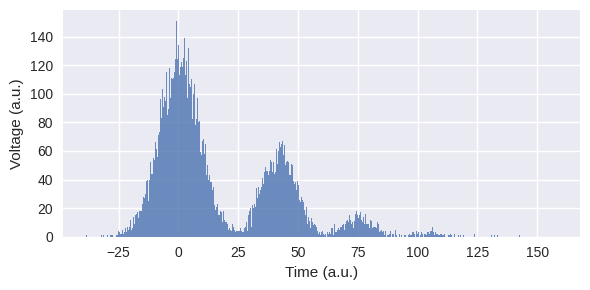

Initial objective function :  [-17216.44683366 -17215.34889094 -17214.94275626 -17214.94320259
 -17215.2302896  -17215.74171029 -17216.43485747 -17217.28215533
 -17218.26298458 -17219.36159687 -17220.25953846]
[-17216.44683366 -17215.34889094 -17214.94275626 -17214.94320259
 -17215.2302896  -17215.74171029 -17216.43485747 -17217.28215533
 -17218.26298458 -17219.36159687 -17220.25953846]


In [41]:
pk = PIKA(
        nCool = 10,
        nGreedy = 10,
        nSigma = 4.,
        verbose = True
        )

pk.fit(
        data =data_train[np.newaxis, :10_000, :], 
        nPhotonAvgList = [3],
      )